# Testing single qubit gates

## Importing relevant modules

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    'axes.labelsize' : 12,})

import copy
from scipy.interpolate import interp1d

# Potential module.
import qudipy.potential as pot

# For solving Schrod eq-n and Stark shift stuff.
import qudipy.qutils as qt
import qudipy.starkshift as ss

# Spin simulator module
import qudipy.spinsimulator.spin_simulator as sps
# Constant pulse generating module
import qudipy.spinsimulator.pulse_generators as pulsegens

# Circuit module containing control pulses and ideal circuits.
import qudipy.circuit as circ


# Control shapes and voltage pulse routines.
from qudipy.control import shapes, voltage_pulses, balance_zeeman

# File Parsers to load data.
from qudipy.circuit import file_parsers

# Constants class.
from qudipy.utils.constants import Constants

# Helper functions
import qudipy.utils.helpers as hp

# Goal of Tutorial
In this tutorial we will be testing single qubit gates in the following steps:
1) Define Voltage Pulses to use as a pulse in the rotation funciton

2) Import nextnano data for a real simulated potential to define the delta_g dependancy 

3) Create a QuantumCircuit from ControlPulse objects to undergo a series of rotations

4) Evolve the Rabi System 

Graphs and plots will be presented throughout the tutorial to give visual representation of the phenomena that we are simulating.

### Voltage pulse parameters

Defining the system constants


In [2]:
csts = Constants('Si/SiO2')

### Defining the voltage parameters: 
Define V_0 as the initial voltage (in Volts), dV as the Voltage offset (in Volts), and f_rf as the ESR resonator frequency (in Hz)

Then define an array of normalized time points (from 0 to 1 seconds)

In [3]:
V_0 = 0.65  # pulse amplitude, V
dV = 0.5    # offset, V

f_rf = 17e9 # ESR resonator frequency, Hz

# Normalized time points.
tau = np.linspace(0, 1, 100)

### Create Voltage Testing Pulses
Define a square, triangle, wide gauss, and narrow gauss pulse shapes by using the shapes module and inputting the voltage parameters that are defined above.

Note that the sigma parameter in the shifted_gauss voltage pulses make the distribution wider.

In [4]:
# Creating 4 testing pulses of different shapes for 0 < tau < 1. 
unit_square = shapes.square(amp=V_0, offset=dV)
unit_triangle = shapes.triangle(amp=V_0, offset=dV)

unit_wide_gauss = shapes.shifted_gauss(amp=V_0, offset=dV, sigma=0.4)
unit_narrow_gauss = shapes.shifted_gauss(amp=V_0, offset=dV, sigma=0.1)


### Plot
Plotting the shapes on a 2 second time interval so that we can see that the offset (dV = 0.5) is placed correctly. The offset will be the middle of the pulse.

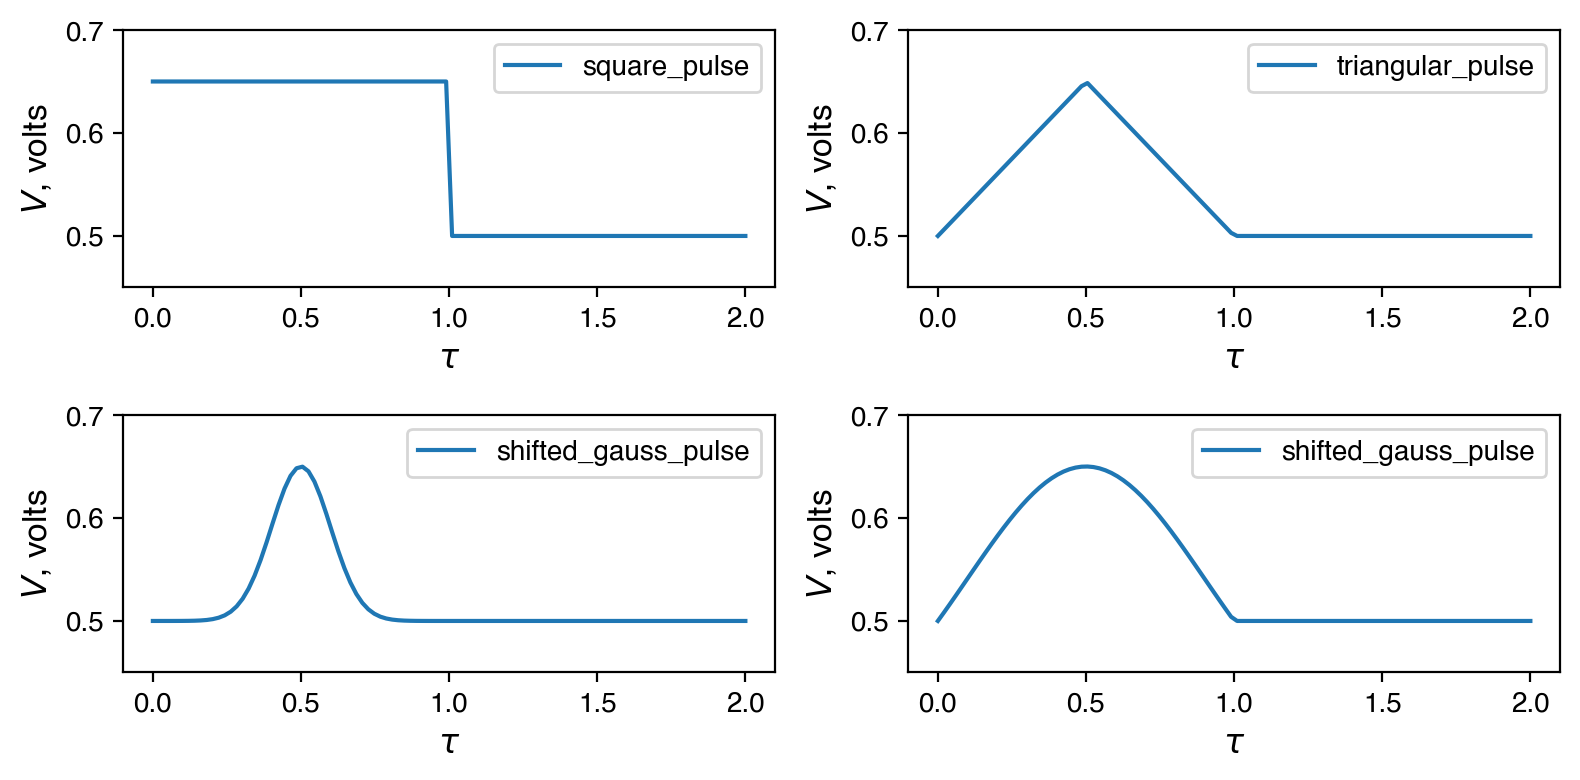

In [5]:
unit_shapes = (unit_square, unit_triangle, unit_narrow_gauss, unit_wide_gauss)

fig, ax = plt.subplots(2,2, figsize=(8,4), dpi=200)
for i, shape in enumerate(unit_shapes):
    ax[i//2, i%2].plot(tau * 2, shape(tau * 2), label=shape.__name__)
    ax[i//2, i%2].legend()
    
    # Setting axes labels.
    ax[i//2, i%2].set_xlabel('$\\tau$', size=12)
    ax[i//2, i%2].set_ylabel('${V}$, volts', size=12)

    ax[i//2, i%2].set_ylim((0.45,0.7))

fig.tight_layout()
plt.show()

## Import nextnano Data

Now, we are ready to import the correct data

In [6]:
input_nextnano = os.path.join(sys.path[0],'QuDiPy tutorial data','Nextnano simulations','1_dot_P_0p5_0p7')
output_preprocessed = os.path.join(sys.path[0],'QuDiPy tutorial data','Pre-processed potentials','Pre-processed_data')

# Importing potential.
potential = pot.process_nextnano.import_dir(input_nextnano, show_files=True)

Importing .coord data files from /1_dot_P_0p5_0p7_t2_VP_0.675:
Importing .dat data files from /1_dot_P_0p5_0p7_t2_VP_0.675:
Importing .coord data files from /1_dot_P_0p5_0p7_t2_VP_0.5:
Importing .dat data files from /1_dot_P_0p5_0p7_t2_VP_0.5:
Importing .coord data files from /1_dot_P_0p5_0p7_t2_VP_0.55:
Importing .dat data files from /1_dot_P_0p5_0p7_t2_VP_0.55:
Importing .coord data files from /1_dot_P_0p5_0p7_t2_VP_0.525:
Importing .coord data files from /1_dot_P_0p5_0p7_t2_VP_0.7:
Importing .dat data files from /1_dot_P_0p5_0p7_t2_VP_0.7:


In [7]:
# Desired Slice
z = 0.45

_, nearest_slice = hp.find_nearest(potential[0]['coord']['z'], z)

print(f'The nearest slice for z = {z} is: {nearest_slice}')

The nearest slice for z = 0.45 is: 0.577831528707


Constructing a z-slice for the data

In [8]:

# Specifying control values and names.
pot_dir = output_preprocessed + '_for_slice_{:.3e}'.format(z) + '/'
ctrl_names = ['VP']

ctrl_vals = np.sort(pot.process_nextnano.retrieve_ctrl_vals(potential)) # Must make sure that ctrl_vals are sorted
ctrl_vals

AttributeError: module 'qudipy.potential.process_nextnano' has no attribute 'retrieve_ctrl_vals'

In [ ]:

# Now we define the field types we wish to write 2D slices for. Either potential or the electric field.
pot.process_nextnano.write_data(input_nextnano,output_preprocessed, slice=z, f_type=['potential','field'])


In [ ]:
loaded_data_pot = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='pot', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='eV')

loaded_data_field = pot.load_potentials(ctrl_vals, ctrl_names,
                                  f_type='electric', f_dir=pot_dir,
                                  f_dis_units='nm', f_pot_units='V/nm')

potential_int = pot.build_interpolator(loaded_data_pot,
                                         constants=csts)
e_field_int = pot.build_interpolator(loaded_data_field,
                                         constants=csts)

potential_int.plot([0.65])
e_field_int.plot([0.65])
#TODO update my matplotlab

## True g(V)
Now we create a ''true'' g-factor dependency on voltage.
First, create a Grid Parameters object:

In [ ]:
# Construct a GridParameters object.

_2d_coords = loaded_data_pot['coords']
gparams = pot.GridParameters(_2d_coords.x, _2d_coords.y)
len(loaded_data_pot['potentials'])

In [ ]:
def true_g_data(grapams, pot_data, e_field_data):
    delta_g_vals = []
    for idx, param in enumerate(pot_data['ctrl_vals']):
        new_pot = pot_data['potentials'][idx]
        gparams.update_potential(new_pot)
        _, e_vecs = qt.solvers.solve_schrodinger_eq(csts, gparams, n_sols=1)
        wf = e_vecs[:,:,0]
        stark_shift = ss.starkshift.StarkShift(gparams, csts)
            # Lambda to do the g-factor of discrete data rather than interpolated.

        dummy_e_int = lambda V: e_field_data['electric'][
                        np.nonzero(np.array(ctrl_vals[0]) == V[0])[0][0]]

        dg = stark_shift.delta_g(dummy_e_int, [param], ctrl_names,
                                             wavefuncs=[wf])['delta_g_1'][0]
        delta_g_vals.append(dg)
    return interp1d(np.array(ctrl_vals[0]), np.sort(delta_g_vals))


delta_g_true = true_g_data(gparams, loaded_data_pot, loaded_data_field)


Plotting $\delta g (V)$ function

In [ ]:

fig, ax = plt.subplots(figsize=(8,4), dpi=100)

ax.plot(ctrl_vals[0], delta_g_true(ctrl_vals[0]) * 1e4, 'r-o' )
ax.set_xlabel('Plunger gate voltage, V')
ax.set_ylabel('Deviation g-factor $\\times 10^{-4}$')
ax.set_yticks([0.7, 0.8,0.9,1])

fig.tight_layout()

print('Slope is',1e4* (delta_g_true(ctrl_vals[0])[-1] - delta_g_true(ctrl_vals[0])[0])/ (ctrl_vals[0][-1]- ctrl_vals[0][0]))

In [ ]:
# def true_g_def(gparams, pot_interp, field_interp):
#     def delta_g(V):
#         new_pot = pot_interp([V])
#         gparams.update_potential(new_pot)
#         e_ens, e_vecs = qt.solvers.solve_schrodinger_eq(csts, gparams, n_sols=1)
#         wf = e_vecs[:,:,0]
#         # pot_interp.plot([V], plot_type='1D', y_slice=0, show_wf=True)
#         stark_shift = ss.starkshift.StarkShift(gparams, csts)
#         dg = stark_shift.delta_g(field_interp, [[V]], ctrl_names, wavefuncs=[wf])['delta_g_1'][0]
#         return dg
#     return np.vectorize(delta_g)


## Specifying spin system parameters

Now we find the value of Zeeman field that ensures no spin rotation during idling

In [ ]:
B_0 = voltage_pulses.balance_zeeman(delta_g_true, dV, f_rf)

f_larmor = e / m_e * B_0/(2 * np.pi )
print('B_0: {} T, \nLarmor frequency: {} GHz.'.format(B_0, f_larmor / 1e9))
                                                   

In [ ]:
# Qubits in a pure  |↑↓> state.

psi_down = np.array([0,1])
psi_up = np.array([1,0]) 

params_rabi = { "f_rf":f_rf, 'B_0':B_0}    # "T_1":2e-4, "T_2":5e-6,

# Creating a spin system; Zeeman field is yet to be specified.
n_qubits = 2
rabi_system = sps.SpinSys((psi_up, psi_down), time=0, **params_rabi)
rho_initial = rabi_system.rho

Now we are generating the ROTZ and ROTX pulses on the 1st qubit when 
the other one is inactive.
Choose the "narrow gaussian" pulse for now

# Create a Quantum Circuit Object

@author: Madi

We will generate 2 qubit system with rotation pulses, we will call a function to build three ControlPulse class objects and save them as .ctrlp files. We will then store them in a QuantumCircuit Class object.

The purpose of this exercise is to show how ControlPulse objects can be created to define rotations, how these ControlPulses can be stored in a QuantumCircuit object, and finaly, how to pull out these rotations from the Quantum Circuit and plot them.

This Tutorial also highlights the functions create_ctlp_file and create_quantum_circuit to move between .ctrlp files and .qcric files as well as ControlPulse Objects and QuantumCircuit objects.

Note that all rotations will have the unit narrow gaussian shape as defined above


In [ ]:
# Specify number of data points -> more points => higher accuracy.
length = 1000

# Create X Rotation by 90 degrees.
XROT = voltage_pulses.rot('X', 90, 2, [1], delta_g_true, unit_narrow_gauss, B_0, num_val = length)

# Create Z Rotation by 90 degrees.
ZROT = voltage_pulses.rot('Z', 90, 2, [1], delta_g_true, unit_narrow_gauss, B_0, num_val = length)

# Create Y Rotation by -90 degrees.
YROT = voltage_pulses.rot('Y', -90, 2, [1], delta_g_true, unit_narrow_gauss, B_0, num_val = length)


# Create .ctrlp files from each pulse.
p1 = voltage_pulses.create_ctlp_file(XROT, read = False, get_dir = True)
p2 = voltage_pulses.create_ctlp_file(ZROT, read = False, get_dir = True)
p3 = voltage_pulses.create_ctlp_file(YROT, read = False, get_dir = True)


# Create a list of Pulses.
pulse_list = [p1, p2, p3]

# Create a QuantumCircuit object and write a .qcirc file.
circ1 = voltage_pulses.create_quantum_circuit(pulse_list, "Circuit 1", write_qcirc = True, print_dir = True)

# Pull out Data and Plot

We will now call out the information that we need to plot these control pulses:

STEP 1) Step through each pulse to retrieve times and pulses, then concatenate all of the control pulses into a data frame

STEP 2) Plot the Voltage Pulses, ESR Pulse, and phase

In [ ]:
# Retrieving all of the ControlPulse objects that are stored in the Quantum Circuit,
# put these pulses into a list.
ctrlp_list = list(circ1.gates.values())
keys_list = list(circ1.gates.keys())



## ** STEP 1 **

# Step through each pulse and record the time, adding onto the time by
# the previous length as we go.
# Use Pandas module to put each pulse in a data frame, 
# step through all of the pulses and put these data frames in a list, 
# then concatenate this list

val = 0
times_list = []
pulses_list = []
for pulse in ctrlp_list:
    # join pulses in a list
    pulses_list = pulses_list + [pd.DataFrame(pulse.ctrl_pulses)]
    
    #join times in a list, shifting over each pulse by the previous pulses' length
    if times_list == []:
        times_list = times_list + [np.linspace(0, pulse.length, length)] 
        val = val + pulse.length
    else:
        times_list = times_list + [val + np.linspace(0, pulse.length, length)]
        val = val + pulse.length
        
joined_pulses = pd.concat(pulses_list)
joined_time = np.concatenate(times_list)



## ** STEP 2 **
# plotting

fig, ax = plt.subplots(2, 1,figsize=(9,5.7), dpi=200)


mus_time = joined_time * 1e6        #in microseconds


###### Voltage pulses #######
ax[0].plot(mus_time, joined_pulses['V_1'] , color='green', label='V$_{1}$')
ax[0].plot(mus_time, joined_pulses['V_2'] , color='magenta', label='V$_{2}$')

ax[0].legend( fontsize='large')
ax[0].set_xlabel("Time, $\mu$s")
ax[0].set_ylabel("Plunger gate voltages")

###### ESR field pulses  #######

ax[1].plot(mus_time, joined_pulses['B_rf'], 
                color='red', label='B$_{RF}$')

ax[1].legend(loc='upper left', fontsize='large')
ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("ESR field, T", color='darkred')

ax[1].tick_params(axis='y', labelcolor='darkred')

####### Plotting phase on the same plot #######

ax_phase = ax[1].twinx()
ax_phase.plot(mus_time, joined_pulses['phi'] * np.pi / 180, 
                color='blue', label='$\phi_{RF}$' )

ax_phase.legend(loc='upper right',fontsize='large')
ax_phase.set_ylabel("Phase, rad", color='blue')


ax_phase.tick_params(axis='y', labelcolor='blue')
ax_phase.set_yticks([0, np.pi/2, np.pi, 3 * np.pi /2, 2* np.pi],)

#vertical lines showing borders between pulses

for axis in ax:
    val = 0
    for pulse in ctrlp_list:
        pulse_len = pulse.length*1e6
        axis.axvline(val + pulse_len, c='gray')
        val = pulse_len



fig.tight_layout()



# Evolving Rabi System

In [ ]:
rabi2 = copy.deepcopy(rabi_system) 

triple_rot_sequence = [XROT, ZROT, YROT]

triple_rot = rabi2.evolve(triple_rot_sequence,     
                               rho_reference = rho_initial, eval_fidelity=True, 
                               track_qubits=(1,2), eval_Bloch_vectors=True, 
                                track_points_per_pulse=100)


In [ ]:
# Plotting the evolution.
fig, ax = plt.subplots(3, 1,figsize=(9,9), dpi=200, gridspec_kw={'height_ratios': [5, 5, 4.5]})

mus_time = triple_rot["time"] * 1e6


###### Bloch vector of the 1st qubit #######
ax[0].plot(mus_time, np.real(triple_rot["sigma_x_1"]) , label='$\\langle\sigma_{x1}\\rangle$')
ax[0].plot(mus_time, np.real(triple_rot["sigma_y_1"]) , label='$\\langle\sigma_{y1}\\rangle$')
ax[0].plot(mus_time, np.real(triple_rot["sigma_z_1"]) , label='$\\langle\sigma_{z1}\\rangle$')

ax[0].legend(loc='lower left', fontsize='large')
ax[0].set_xlabel("Time, $\mu$s")
ax[0].set_ylabel("Bloch vector")

ax[0].text(10, 0.8, '1st qubit', fontsize=14,)

###### Bloch vector of the 2nd qubit #######
ax[1].plot(mus_time, np.real(triple_rot["sigma_x_2"]) , color='red', label='$\\langle\sigma_{x2}\\rangle$', )
ax[1].plot(mus_time, np.real(triple_rot["sigma_y_2"]) , color='green',  label='$\\langle\sigma_{y2}\\rangle$', )
ax[1].plot(mus_time, np.real(triple_rot["sigma_z_2"]) , color='magenta', label='$\\langle\sigma_{z2}\\rangle$')

ax[1].legend(loc='lower left', fontsize='large')
ax[1].set_xlabel("Time, $\mu$s")
ax[1].set_ylabel("Bloch vector")

ax[1].text(10, -0.6, '2nd qubit', fontsize=14,)


##### Plotting fidelity

ax[2].plot(mus_time, triple_rot['fidelity'], 'b-', label='Fidelity')
ax[2].set_xlabel("Time, $\mu$s")
ax[2].set_ylabel("Fidelity")
ax[2].legend( fontsize='large')

ax[2].text(33, 0.65,
            'Infidelity \nat the end: \n{:.3e}'.format(1 - triple_rot['fidelity'][-1]),
                         fontsize=14, )

# Vertical lines showing borders between pulses.
for axis in ax:
    axis.axvline(XROT.length*1e6, c='gray' )
    axis.axvline((XROT.length+ ZROT.length)*1e6, c='gray')
fig.tight_layout()